In [1]:
# Import libraries
import numpy as np
np.random.seed(42)
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 20})

In [2]:
# Define the objective function

def obj(x):
    return np.sin(x) + np.sin(10 * x / 3)

lower_bound = 2.7
upper_bound = 7.5



In [3]:
# Fit a GP
x_train = np.random.rand(6).reshape((-1, 1))
x_train = x_train * (upper_bound - lower_bound) + lower_bound
y_train = obj(x_train)
kernel = ConstantKernel() * RBF(length_scale=1.0, length_scale_bounds=(1e-10, 1e6)) 

model = GaussianProcessRegressor(kernel, n_restarts_optimizer=10)

_ = model.fit(x_train, y_train)


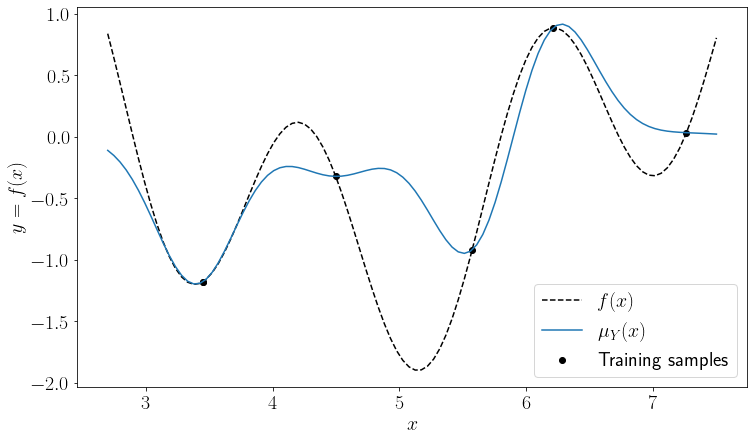

In [4]:
# Visualize mean acquisition
x_grid = np.linspace(lower_bound, upper_bound, 100)
y_true = obj(x_grid)
y_pred_mu, y_pred_std = model.predict(x_grid.reshape((-1, 1)), return_std=True)
y_pred_mu = y_pred_mu.ravel()

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
plt.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
_ = ax.legend()


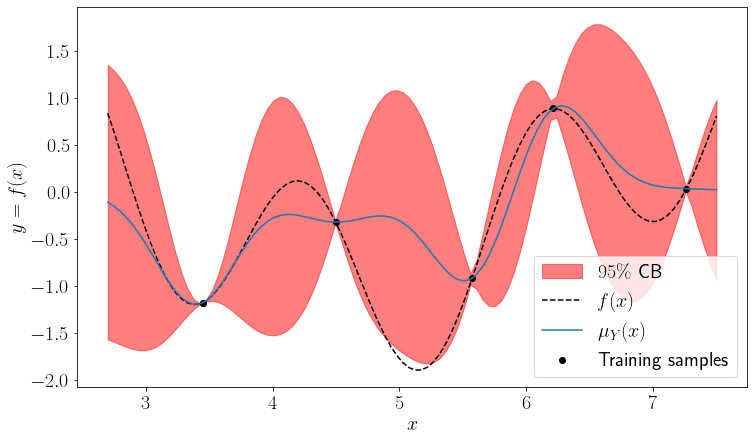

In [5]:
y_lcb = y_pred_mu - 1.96 * y_pred_std 
y_ucb = y_pred_mu + 1.96 * y_pred_std

fig, ax = plt.subplots(figsize=(12, 7))
ax.fill_between(x_grid, y_lcb, y_ucb, alpha=0.5, color="red", label="$95\%$ CB")
ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
_ = ax.legend()

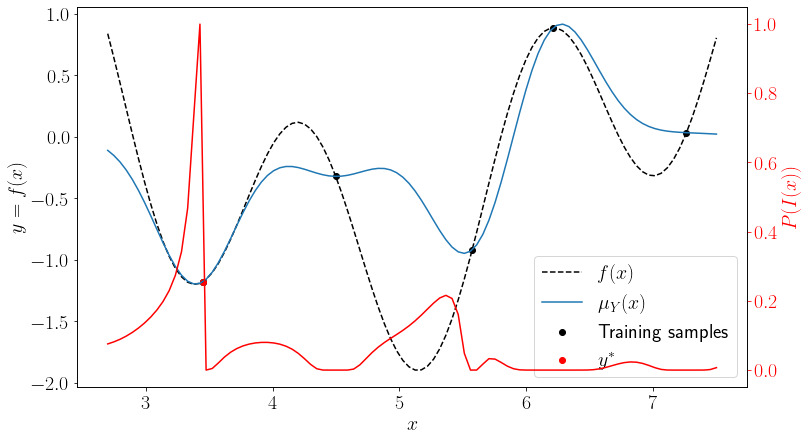

In [6]:
star = np.argmin(y_train)
x_star = x_train[star]
y_star = y_train[star]
y_pi = norm().cdf((y_star - y_pred_mu)/ y_pred_std)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.scatter(x_star, y_star, label="$y^*$", color="r")
ax2 = ax.twinx()
ax2.plot(x_grid, y_pi, color="r")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
ax2.set_ylabel("$P(I(x))$")
ax2.yaxis.label.set_color("r")
ax2.tick_params(axis='y', colors='red')
_ = ax.legend()

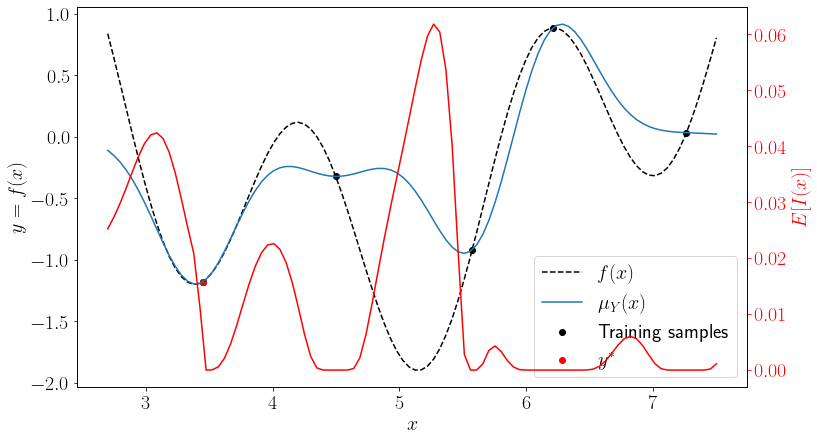

In [7]:
z = (y_star - y_pred_mu)/ y_pred_std
y_ei = (y_star - y_pred_mu) * norm().cdf(z) + y_pred_std * norm().pdf(z)
y_ei[y_pred_std <=0] = 0 # Not part of the derivation above but useful in practice to avoid repeated samples

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.scatter(x_star, y_star, label="$y^*$", color="r")
ax2 = ax.twinx()
ax2.plot(x_grid, y_ei, color="r")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
ax2.set_ylabel("$E[I(x)]$")
ax2.yaxis.label.set_color("r")
ax2.tick_params(axis='y', colors='red')
_ = ax.legend()

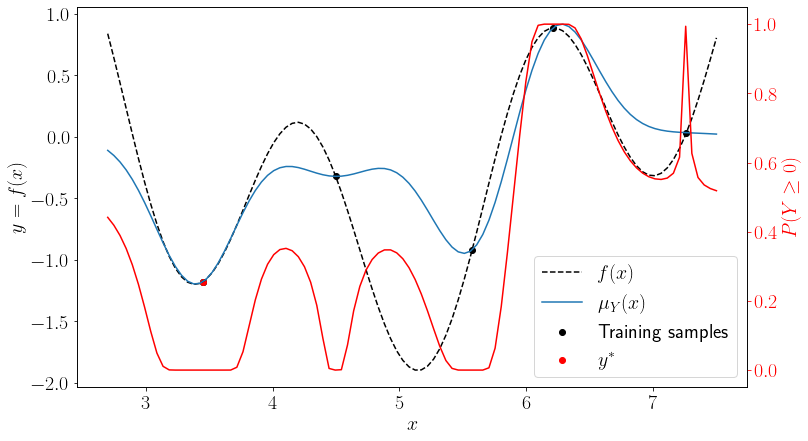

In [8]:
p_f = norm().cdf(y_pred_mu / y_pred_std)


fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.scatter(x_star, y_star, label="$y^*$", color="r")
ax2 = ax.twinx()
ax2.plot(x_grid, p_f, color="r")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
ax2.set_ylabel("$P(Y \geq 0)$")
ax2.yaxis.label.set_color("r")
ax2.tick_params(axis='y', colors='red')
_ = ax.legend()

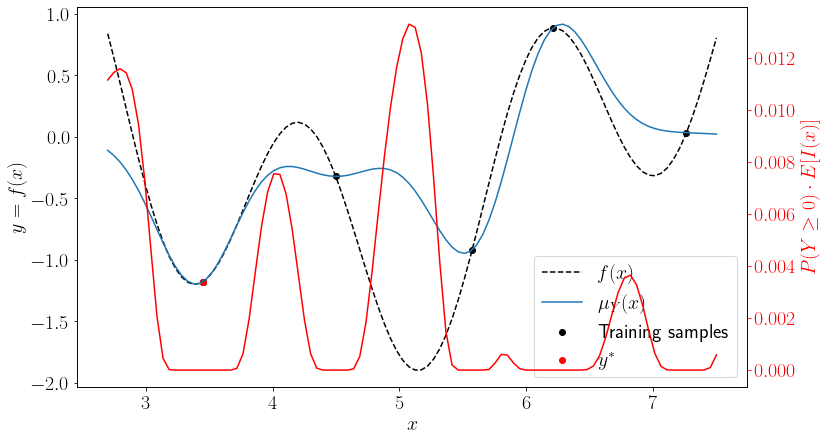

In [9]:
a_c = p_f * y_ei

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x_grid, y_true, "--k", label="$f(x)$")
ax.plot(x_grid, y_pred_mu, label="$\mu_Y(x)$")
ax.scatter(x_train.ravel(), y_train.ravel(), label="Training samples", color="k")
ax.scatter(x_star, y_star, label="$y^*$", color="r")
ax2 = ax.twinx()
ax2.plot(x_grid, a_c, color="r")
ax.set_xlabel("$x$")
ax.set_ylabel("$y=f(x)$")
ax2.set_ylabel("$P(Y \geq 0) \cdot E[I(x)]$")
ax2.yaxis.label.set_color("r")
ax2.tick_params(axis='y', colors='red')
_ = ax.legend()